In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [27]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as o
import geotorch
import torchvision.transforms as t

from copy import deepcopy

from torchvision.datasets import MNIST
from torchsummary import summary
from tqdm import tqdm

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.solvers import OTSolver
from src.plotters import SyntheticPlotter, GMMPlotter
from src.utils import *
from src.models.resnet import resnet18_d, resnet18_g

In [28]:
if torch.cuda.is_available():
    torch.cuda.set_device(2)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_")

In [63]:
def load_mnist(root, transform=None):
    dataset = MNIST(root, transform=transform, download=True)
    images, targets = [], []
    for image, target in tqdm(dataset):
        images.append(image)
        targets.append(target)
    return torch.stack(images), torch.tensor(targets)

## Define source and target distributions

In [31]:
target_dim = (1, 32, 32)
p, q = 2, np.prod(target_dim, dtype=int)

n_components = 10

locs = 2 * uniform_circle(n_components)
scales = .3 * torch.ones(n_components, p)
target = gaussian_mixture(locs, scales)

features, classes = load_mnist("../data/",
                               transform=t.Compose([t.Pad(2), t.ToTensor()]))
target = TensorDatasetDistribution(features, classes)

100%|██████████| 60000/60000 [00:17<00:00, 3353.10it/s]


In [32]:
n_neurons = 128

critic = resnet18_d(target_dim)
summary(critic, target_dim, batch_size=512)

mover = resnet18_g(target_dim, q)
summary(mover, (q,), batch_size=512)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [512, 64, 16, 16]           3,136
       BatchNorm2d-2          [512, 64, 16, 16]             128
         LeakyReLU-3          [512, 64, 16, 16]               0
         MaxPool2d-4            [512, 64, 8, 8]               0
            Conv2d-5            [512, 64, 8, 8]          36,864
       BatchNorm2d-6            [512, 64, 8, 8]             128
         LeakyReLU-7            [512, 64, 8, 8]               0
            Conv2d-8            [512, 64, 8, 8]          36,864
       BatchNorm2d-9            [512, 64, 8, 8]             128
     EncoderBlock-10            [512, 64, 8, 8]               0
           Conv2d-11            [512, 64, 8, 8]          36,864
      BatchNorm2d-12            [512, 64, 8, 8]             128
        LeakyReLU-13            [512, 64, 8, 8]               0
           Conv2d-14            [512, 6

In [22]:
class InnerGW:
    def __init__(self, l=.05):
        self.l = l

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        P = torch.einsum("ij,ik->jk", y, x)
        P = P / torch.norm(P)
        return self.l * torch.norm(x @ P.T - y, 2, dim=1) ** 2

In [31]:
p, q = 3, 3
n_neurons = 32

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [32]:
def run_experiment(source, target, cost, n_iter,
                   plotter, logger=None, **kwargs):
    if logger: logger.start()
    try:
        OTSolver(deepcopy(critic), deepcopy(mover), cost=cost,
                plotter=plotter, logger=logger,
                **kwargs).fit(source, target, n_iter)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()

In [33]:
n_components = 7

locs = 2 * fibonacci_sphere(n_components)
scales = .1 * torch.ones(n_components, p)
source = gaussian_mixture(locs, scales)

locs =  fibonacci_sphere(n_components)
scales = .3 * torch.ones(n_components, q)
target = gaussian_mixture(locs, scales)

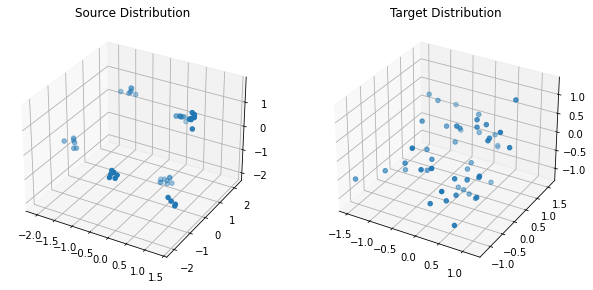

Output()

  0%|          | 0/1000 [00:00<?, ?it/s]

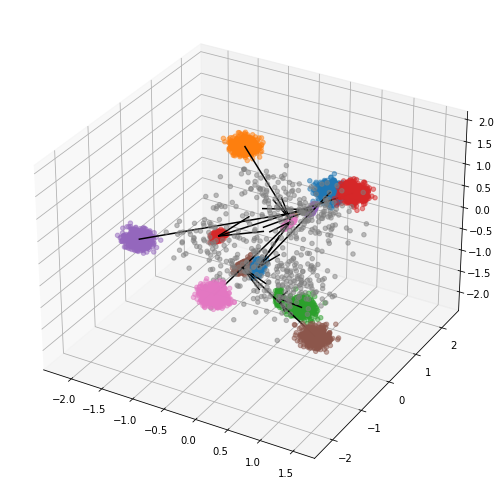

In [35]:
run_experiment(
    source, target,
    n_iter=1000,
    cost=InnerGW(),
    plotter=GMMPlotter(p, q),
    # logger=wandb_logger
)